In [1]:
import collections
import re
from datetime import datetime, timezone

import codebook
import numpy as np
import pandas as pd
import scipy.stats as scs
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

pd.options.display.max_rows = 500
pd.options.display.max_columns = 200

labels = codebook.variable_labels()
encodings = codebook.student_encodings()

# Load Data

In [2]:
rdf = pd.read_feather("hsls_17_student_pets_sr_v1_0.feather")
rdf.head()

,STU_ID,SCH_ID,X1NCESID,X2NCESID,STRAT_ID,PSU,X2UNIV1,X2UNIV2A,X2UNIV2B,X3UNIV1,X4UNIV1,W1STUDENT,W1PARENT,W1MATHTCH,W1SCITCH,W2STUDENT,W2W1STU,W2PARENT,W2W1PAR,W3STUDENT,W3W1STU,W3W1W2STU,W3W2STU,W3HSTRANS,W3STUDENTTR,W3W1STUTR,W3W1W2STUTR,W3W2STUTR,W4STUDENT,W4W1STU,W4W1STUP1,W4W1STUP1P2,W4W1W2W3STU,W5PSTRANS,W5PSRECORDS,W5W1W2W3W4PSTRANS,W5W1W2W3W4PSRECORDS,W3W1MATHTCH,W3W1SCITCH,X1SEX,X1RACE,X1HISPANIC,X1WHITE,X1BLACK,X1ASIAN,X1PACISLE,X1AMINDIAN,X1HISPTYPE,X1ASIANTYPE,X1NATIVELANG,X1DUALLANG,X1STDOB,X1TXMTH,X1TXMSEM,X1TXMSCR,X1TXMTSCOR,X1TXMQUINT,X1TXMPROF1,X1TXMPROF2,X1TXMPROF3,X1TXMPROF4,X1TXMPROF5,X1MACC,X1PARRESP,X1P1RELATION,X1PAR1EDU,X1PAR1EMP,X1PAR1OCC2,X1PAR1OCC6,X1PAR1OCC_STEM1,X1PAR1OCC_STEM2,X1PAR1RACE,X1P2RELATION,X1PAR2EDU,X1PAR2EMP,X1PAR2OCC2,X1PAR2OCC6,X1PAR2OCC_STEM1,X1PAR2OCC_STEM2,X1PAR2RACE,X1PAREDU,X1PARPATTERN,X1MOMRESP,X1MOMREL,X1MOMEDU,X1MOMEMP,X1MOMOCC2,X1MOMOCC6,X1MOMOCC_STEM1,X1MOMOCC_STEM2,X1MOMRACE,X1DADRESP,X1DADREL,X1DADEDU,X1DADEMP,X1DADOCC2,X1DADOCC6,X1DADOCC_STEM1,X1DADOCC_STEM2,X1DADRACE,...,W5W1W2W3W4PSRECORDS101,W5W1W2W3W4PSRECORDS102,W5W1W2W3W4PSRECORDS103,W5W1W2W3W4PSRECORDS104,W5W1W2W3W4PSRECORDS105,W5W1W2W3W4PSRECORDS106,W5W1W2W3W4PSRECORDS107,W5W1W2W3W4PSRECORDS108,W5W1W2W3W4PSRECORDS109,W5W1W2W3W4PSRECORDS110,W5W1W2W3W4PSRECORDS111,W5W1W2W3W4PSRECORDS112,W5W1W2W3W4PSRECORDS113,W5W1W2W3W4PSRECORDS114,W5W1W2W3W4PSRECORDS115,W5W1W2W3W4PSRECORDS116,W5W1W2W3W4PSRECORDS117,W5W1W2W3W4PSRECORDS118,W5W1W2W3W4PSRECORDS119,W5W1W2W3W4PSRECORDS120,W5W1W2W3W4PSRECORDS121,W5W1W2W3W4PSRECORDS122,W5W1W2W3W4PSRECORDS123,W5W1W2W3W4PSRECORDS124,W5W1W2W3W4PSRECORDS125,W5W1W2W3W4PSRECORDS126,W5W1W2W3W4PSRECORDS127,W5W1W2W3W4PSRECORDS128,W5W1W2W3W4PSRECORDS129,W5W1W2W3W4PSRECORDS130,W5W1W2W3W4PSRECORDS131,W5W1W2W3W4PSRECORDS132,W5W1W2W3W4PSRECORDS133,W5W1W2W3W4PSRECORDS134,W5W1W2W3W4PSRECORDS135,W5W1W2W3W4PSRECORDS136,W5W1W2W3W4PSRECORDS137,W5W1W2W3W4PSRECORDS138,W5W1W2W3W4PSRECORDS139,W5W1W2W3W4PSRECORDS140,W5W1W2W3W4PSRECORDS141,W5W1W2W3W4PSRECORDS142,W5W1W2W3W4PSRECORDS143,W5W1W2W3W4PSRECORDS144,W5W1W2W3W4PSRECORDS145,W5W1W2W3W4PSRECORDS146,W5W1W2W3W4PSRECORDS147,W5W1W2W3W4PSRECORDS148,W5W1W2W3W4PSRECORDS149,W5W1W2W3W4PSRECORDS150,W5W1W2W3W4PSRECORDS151,W5W1W2W3W4PSRECORDS152,W5W1W2W3W4PSRECORDS153,W5W1W2W3W4PSRECORDS154,W5W1W2W3W4PSRECORDS155,W5W1W2W3W4PSRECORDS156,W5W1W2W3W4PSRECORDS157,W5W1W2W3W4PSRECORDS158,W5W1W2W3W4PSRECORDS159,W5W1W2W3W4PSRECORDS160,W5W1W2W3W4PSRECORDS161,W5W1W2W3W4PSRECORDS162,W5W1W2W3W4PSRECORDS163,W5W1W2W3W4PSRECORDS164,W5W1W2W3W4PSRECORDS165,W5W1W2W3W4PSRECORDS166,W5W1W2W3W4PSRECORDS167,W5W1W2W3W4PSRECORDS168,W5W1W2W3W4PSRECORDS169,W5W1W2W3W4PSRECORDS170,W5W1W2W3W4PSRECORDS171,W5W1W2W3W4PSRECORDS172,W5W1W2W3W4PSRECORDS173,W5W1W2W3W4PSRECORDS174,W5W1W2W3W4PSRECORDS175,W5W1W2W3W4PSRECORDS176,W5W1W2W3W4PSRECORDS177,W5W1W2W3W4PSRECORDS178,W5W1W2W3W4PSRECORDS179,W5W1W2W3W4PSRECORDS180,W5W1W2W3W4PSRECORDS181,W5W1W2W3W4PSRECORDS182,W5W1W2W3W4PSRECORDS183,W5W1W2W3W4PSRECORDS184,W5W1W2W3W4PSRECORDS185,W5W1W2W3W4PSRECORDS186,W5W1W2W3W4PSRECORDS187,W5W1W2W3W4PSRECORDS188,W5W1W2W3W4PSRECORDS189,W5W1W2W3W4PSRECORDS190,W5W1W2W3W4PSRECORDS191,W5W1W2W3W4PSRECORDS192,W5W1W2W3W4PSRECORDS193,W5W1W2W3W4PSRECORDS194,W5W1W2W3W4PSRECORDS195,W5W1W2W3W4PSRECORDS196,W5W1W2W3W4PSRECORDS197,W5W1W2W3W4PSRECORDS198,W5W1W2W3W4PSRECORDS199,W5W1W2W3W4PSRECORDS200
0,10001,-5,-5,-5,-5,-5,11,1,1,1111,11111,375.667105,470.250141,423.238620,393.169508,365.607062,363.091114,860.151671,1087.442922,392.215779,393.966458,401.342913,379.656157,353.724466,378.525955,423.160870,411.922366,403.128362,466.860846,470.949562,503.197457,1031.658593,482.060060,514.833768,810.319031,609.600783,964.127534,452.117697,433.664830,1,8,0,1,0,-5,-5,-5,-5,-5,-5,1,199502,0.8304,0.2549,50.4919,59.3710,5,0.9997,0.9669,0.8976,0.3126,0.1013,0,1,2,5,4,21,-5,0,-5,8,1,5,4,29,-5,4,-5,8,5,1,0,1,5,4,29,-5,4,-5,8,1,1,5,4,21,-5,0,-5,8,...,1528.456975,2791.70937,1877.721108,1635.74366,0.0,1789.2432,1777.210781,0.0,0.0,0.0,0.0,2094.256669,0.0,216

### Questions answered by students

In [3]:
df = rdf.copy()

columns = [
    "STU_ID",
    "X1RACE",
    "X1WHITE",
    "X1SEX",
    "X1SESQ5",
    "X1SESQ5_U",
    "X1SES_IM",
    "X1FAMINCOME",
    "X4PS1LEVEL",
    "X3REGION",
    "X1LOCALE",
    #"P1MTHCOMP",
    #"P1SCICOMP",
    "S1MTCHMFDIFF",
    "S1STCHMFDIFF",
    "S1MTHCOMP",
    "S1SCICOMP",
    "X1TXMQUINT",
    "X1TXMATH_IM",
    "S1MPERSON1",
    "S1MPERSON2",
    "S2MPERSON1",
    "S4MPERSON1",
    "S1SPERSON1",
    "S1SPERSON2",
    "S2SPERSON1",
    "S4SPERSON1",
    "S1MUNDERST",
    "S1SUNDERST",
    "X5STEM1GPA",
    "S3FIELD_STEM",
    "X4ENTMJST",
    # "M1BELIEVE",
    # "M1INTEREST",
    # "M1MTHCOMP",
    # "M1SCICOMP",
    # "N1BELIEVE",
    # "N1INTEREST",
    # "N1MTHCOMP",
    # "N1SCICOMP",
    "S1FRNDTALKM",
    "S1FRNDTALKS",
    "S1TEFRNDS",
    "S1TEPOPULAR",
    "S1TEMAKEFUN",
    "S1MREASFRND",
    "S1SREASFRND",
    #"P1CAMPMS",
    #"P1JOBONET1_STEM1",
    #"P1JOBONET2_STEM1",
    #"P1STEMDISC",
    # "P1MUSEUM",
    # "P1COMPUTER",
    # "P1FIXED",
    # "P1SCIFAIR",
    # "P1SCIPROJ",
    # "P1MTHHWEFF",
    # "P1SCIHWEFF",
    "W4W1W2W3STU",
]

for duplicate_column in pd.Series(columns).value_counts()[lambda s: s > 1].index:
    raise ValueError(f"Duplicate column: {duplicate_column}")


def factorize(df, columns=None):
    if columns is None:
        columns = df.columns
    return df.assign(
        **{c: df[c].cat.codes for c in columns if c in encodings.keys()}
    )


df = (
    df[columns]
    .pipe(
        lambda df: df.assign(
            **{
                c: codebook.to_categorical(df[c])
                for c in df.columns
                if c in encodings.keys()
            }
        )
    )
    .pipe(
        lambda df: df.assign(
            **{
                c: df[c].apply(lambda x: np.nan if x < 0 else x)
                for c in df.columns
                if c not in encodings.keys()
            }
        )
    )
    .pipe(lambda df: df.assign(INCLUDE=(df.isna() == False).apply(all, axis=1)))
)

# df.pipe(codebook.relabel).head()
df.head()

,STU_ID,X1RACE,X1WHITE,X1SEX,X1SESQ5,X1SESQ5_U,X1SES_IM,X1FAMINCOME,X4PS1LEVEL,X3REGION,X1LOCALE,S1MTCHMFDIFF,S1STCHMFDIFF,S1MTHCOMP,S1SCICOMP,X1TXMQUINT,X1TXMATH_IM,S1MPERSON1,S1MPERSON2,S2MPERSON1,S4MPERSON1,S1SPERSON1,S1SPERSON2,S2SPERSON1,S4SPERSON1,S1MUNDERST,S1SUNDERST,X5STEM1GPA,S3FIELD_STEM,X4ENTMJST,S1FRNDTALKM,S1FRNDTALKS,S1TEFRNDS,S1TEPOPULAR,S1TEMAKEFUN,S1MREASFRND,S1SREASFRND,W4W1W2W3STU,INCLUDE
0,10001,"White, non-Hispanic",Student is White,Male,Fifth quintile (highest),Fifth quintile (highest),Not Imputed,"Family income > $175,000 and <= $195,000",2-year,Midwest,Rural,Disagree,Disagree,Females and males are the same,Females and males are the same,Fifth (highest) quintile,Not Imputed,Strongly agree,Strongly agree,Disagree,Agree,Agree,Agree,Agree,Strongly agree,Often,Often,3.7,No,NaN,No,No,Disagree,Disagree,Agree,No,No,482.060060,False
1,10002,"White, non-Hispanic",Student is White,Female,Second quintile,Second quintile,Not Imputed,"Family income > $35,000 and <= $55,000",4-year,Northeast,Rural,Strongly disagree,Strongly disagree,Males are somewhat better,Females and males are the same,Second quintile,Imputed,Disagree,Disagree,Disagree,Agree,Agree,Agree,Disagree,Agree,Sometimes,Often,NaN,No,No,Yes,Yes,Agree,Strongly disagree,Disagree,Yes,Yes,288.715715,False
2,10003,"Black/African-American, non-Hispanic",Student is not White,Female,Fifth quintile (highest),Fifth quintile (highest),Not Imputed,"Family income > $95,000 and <= $115,000",4-year,West,Suburb,Strongly disagree,Strongly disagree,Females and males are the same,Females and males are the same,Fifth (highest) quintile,Not Imputed,Disagree,Disagree,Strongly disagree,Strongly agree,Disagree,Disagree,Strongly disagree,Strongly agree,Often,Sometimes,2.7,No,Yes,No,No,Strongly disagree,Strongly disagree,Strongly disagree,No,No,187.118031,True
3,10004,"White, non-Hispanic",Student is White,Female,Fifth quintile (highest),Fourth quintile,Not Imputed,"Family income > $75,000 and <= $95,000",NaN,South,Suburb,Disagree,Disagree,Females and males are the same,Females and males are the same,Third (middle) quintile,Not Imputed,Agree,Agree,NaN,NaN,Disagree,Disagree,NaN,NaN,Sometimes,Sometimes,NaN,NaN,NaN,Yes,Yes,Disagree,Disagree,Disagree,No,No,0.000000,False
4,10005,"White, non-Hispanic",Student is White,Male,Fourth quintile,Fourth quintile,Not Imputed,"Family income > $155,000 and <=$175,000",NaN,South,City,Strongly disagree,Agree,Females and males are the same,Females and males are the same,Fifth (highest) quintile,Not Imputed,Strongly agree,Disagree,NaN,Disagree,Disagree,Disagree,Strongly agree,Disagree,Often,Often,NaN,No,NaN,Yes,Yes,Agree,Strongly agree,Strongly agree,No,No,170.727793,False


In [4]:
#The original sample
df.shape

(23503, 39)

In [5]:
#Students who have data through 3 years post high school graduation
tdf = df[df["INCLUDE"]]
tdf.shape

(3712, 39)

In [6]:
student_items = [
    "X1TXMQUINT",
    "S1MPERSON2",
    "S1FRNDTALKM",
    "S1TEFRNDS",
    "S1TEPOPULAR",
    "S1TEMAKEFUN",
    "S1MREASFRND"
    ]

In [7]:
def define_plot(item):
    display(Markdown(f"### {item}: {codebook.variable_labels()[item]}"))
    g = sns.catplot(y=item, x="S1MPERSON1", col="X1SEX", kind="bar", data=df[df["INCLUDE"]].pipe(factorize, columns=["S1MPERSON1"]))
    g = sns.catplot(y=item, x="S2MPERSON1", col="X1SEX", kind="bar", data=df[df["INCLUDE"]].pipe(factorize, columns=["S2MPERSON1"]))
    g = sns.catplot(y=item, x="S4MPERSON1", col="X1SEX", kind="bar", data=df[df["INCLUDE"]].pipe(factorize, columns=["S4MPERSON1"]))
    plt.show()

#### Note about the following charts

- Each chart shows how each question (administered in 9th grade) is or isn't linked to students' identification with math
- Under each question, there are 3 bar charts with students' identification with math on the X-axis in 9th grade, 11th grade, and 3 years post high school graduation respectively.

### X1TXMQUINT: X1 Mathematics quintile score

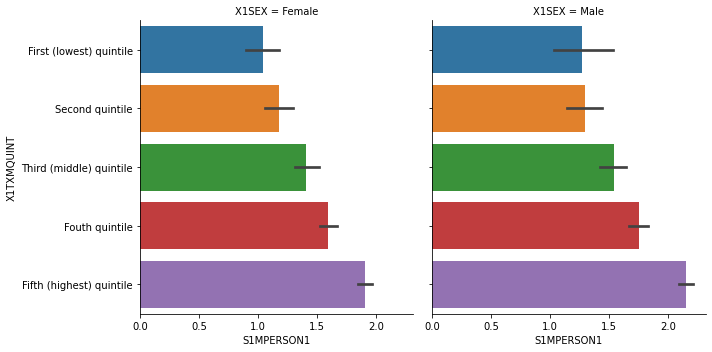

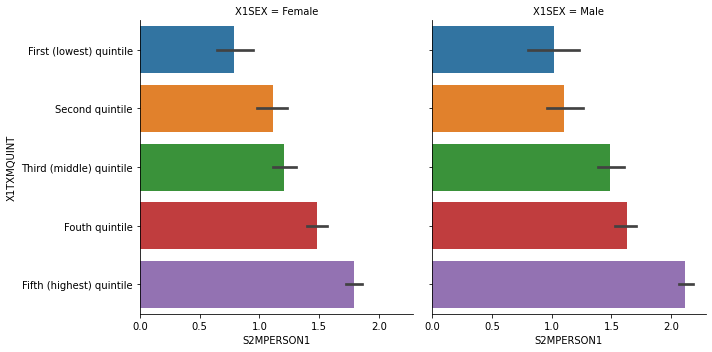

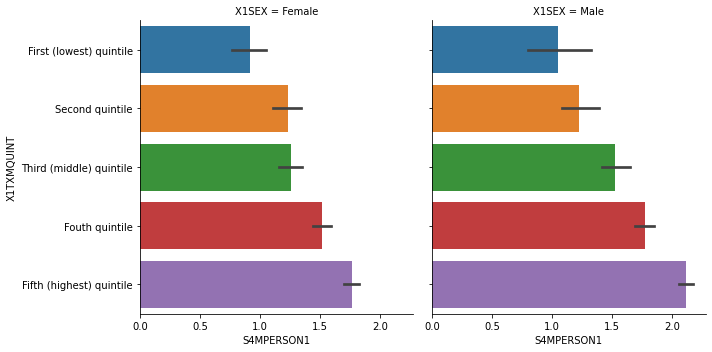

### S1MPERSON2: S1 C01B Others see 9th grader as a math person

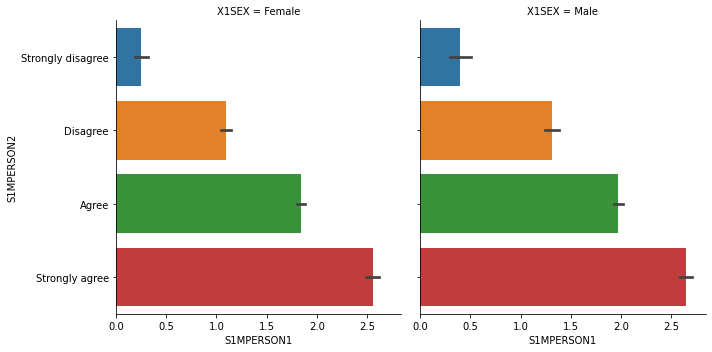

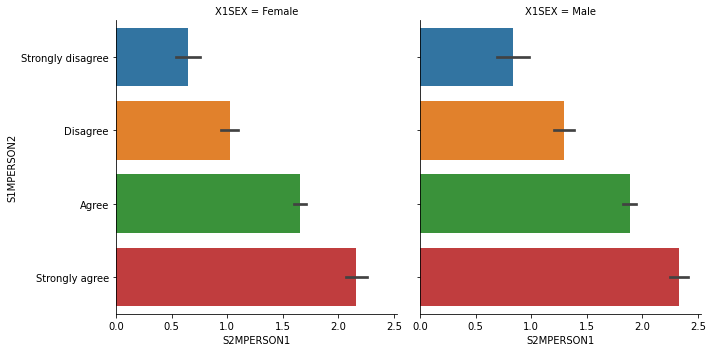

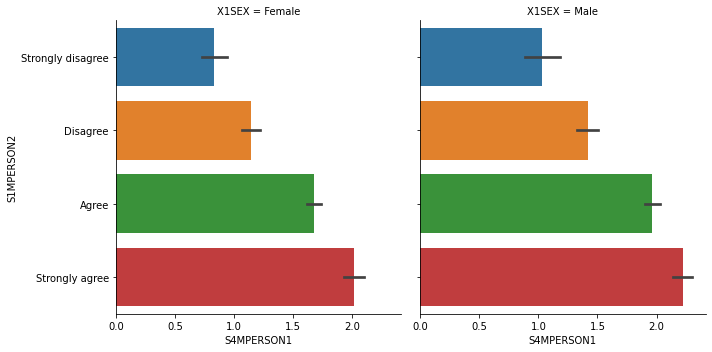

### S1FRNDTALKM: S1 E06C 9th grader talked to friends about math courses to take in 2009-2010

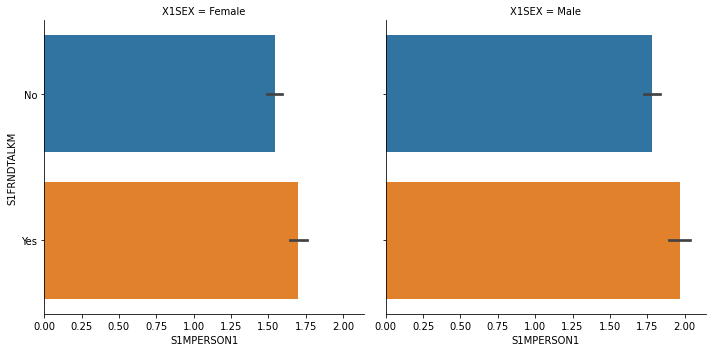

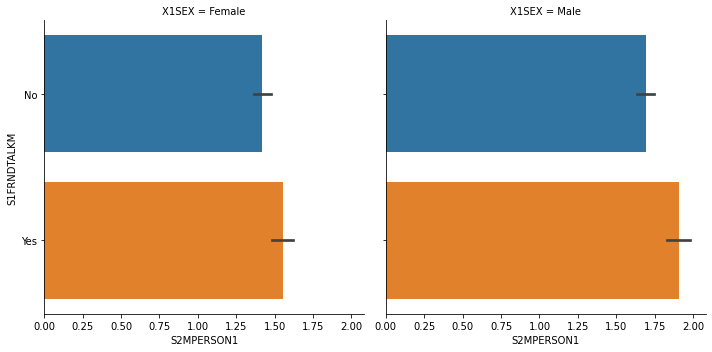

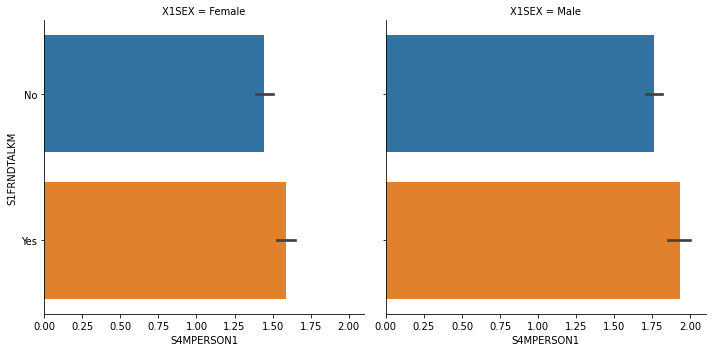

### S1TEFRNDS: S1 E13A Time/effort in math/science means not enough time with friends

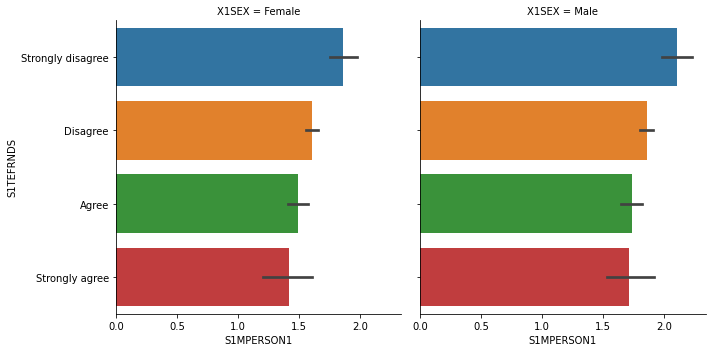

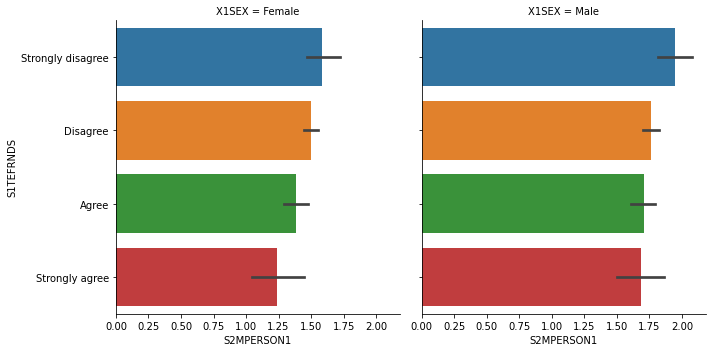

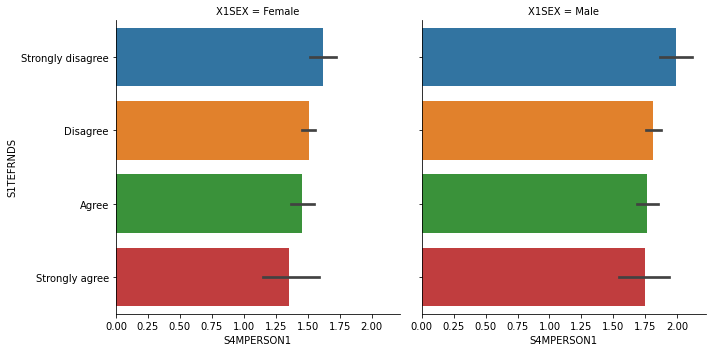

### S1TEPOPULAR: S1 E13C Time/effort in math/science means 9th grader won't be popular

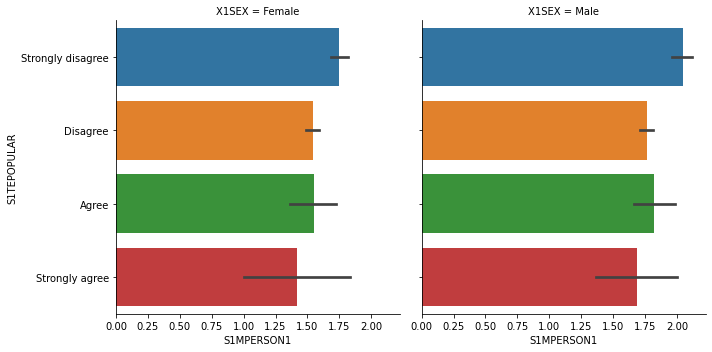

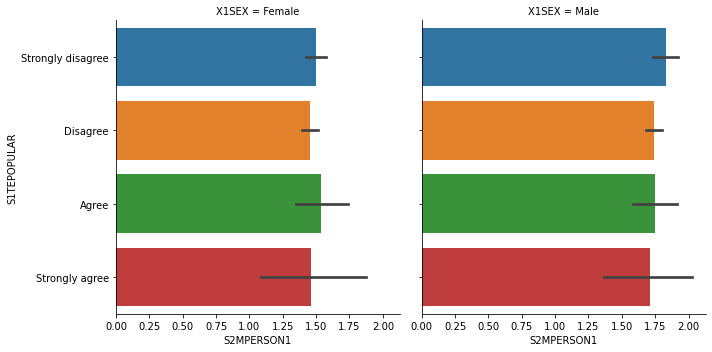

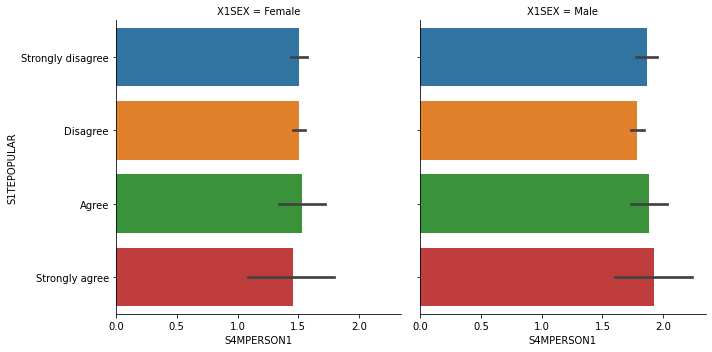

### S1TEMAKEFUN: S1 E13D Time/effort in math/science means people will make fun of 9th grader

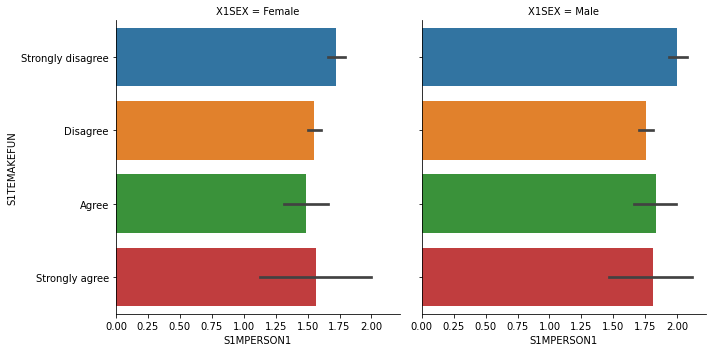

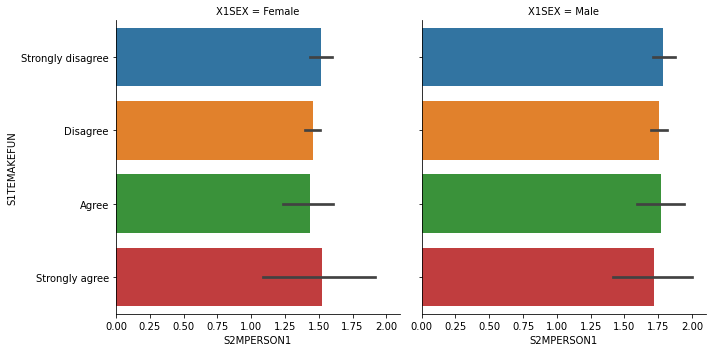

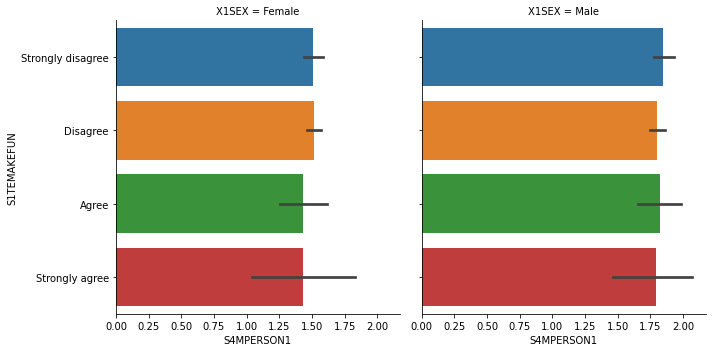

### S1MREASFRND: S1 F02K Plans to take more math courses because friends are going to

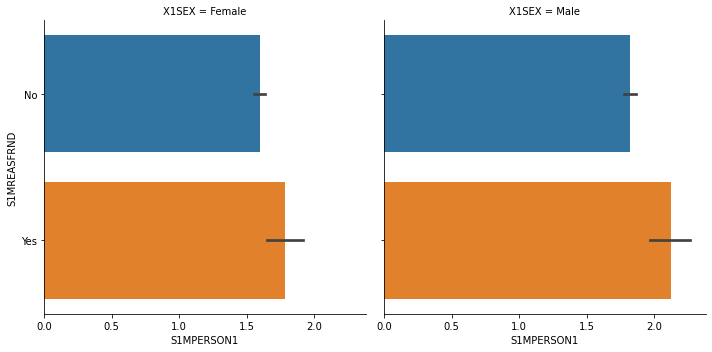

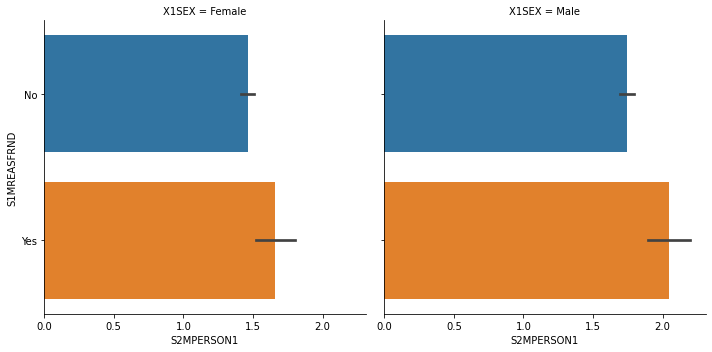

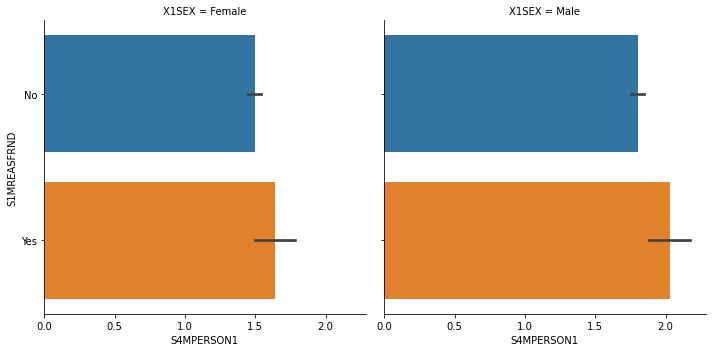

In [8]:
for item in student_items:
    define_plot(item)

### Questions answered by parents

In [9]:
df = rdf.copy()

columns = [
    "STU_ID",
    "X1RACE",
    "X1WHITE",
    "X1SEX",
    "X1SESQ5",
    "X1SESQ5_U",
    "X1SES_IM",
    "X1FAMINCOME",
    "X4PS1LEVEL",
    "X3REGION",
    "X1LOCALE",
    "P1MTHCOMP",
    "P1SCICOMP",
    "S1MTCHMFDIFF",
    "S1STCHMFDIFF",
    "S1MTHCOMP",
    "S1SCICOMP",
    "X1TXMQUINT",
    "X1TXMATH_IM",
    "S1MPERSON1",
    "S1MPERSON2",
    "S2MPERSON1",
    "S4MPERSON1",
    "S1SPERSON1",
    "S1SPERSON2",
    "S2SPERSON1",
    "S4SPERSON1",
    "S1MUNDERST",
    "S1SUNDERST",
    "X5STEM1GPA",
    "S3FIELD_STEM",
    "X4ENTMJST",
    # "M1BELIEVE",
    # "M1INTEREST",
    # "M1MTHCOMP",
    # "M1SCICOMP",
    # "N1BELIEVE",
    # "N1INTEREST",
    # "N1MTHCOMP",
    # "N1SCICOMP",
    "S1FRNDTALKM",
    "S1FRNDTALKS",
    "S1TEFRNDS",
    "S1TEPOPULAR",
    "S1TEMAKEFUN",
    "S1MREASFRND",
    "S1SREASFRND",
    "P1CAMPMS",
    "P1JOBONET1_STEM1",
    "P1JOBONET2_STEM1",
    "P1STEMDISC",
    "P1MUSEUM",
    "P1COMPUTER",
    "P1FIXED",
    "P1SCIFAIR",
    "P1SCIPROJ",
    "P1MTHHWEFF",
    "P1SCIHWEFF",
    "W4W1W2W3STU",
]

for duplicate_column in pd.Series(columns).value_counts()[lambda s: s > 1].index:
    raise ValueError(f"Duplicate column: {duplicate_column}")


def factorize(df, columns=None):
    if columns is None:
        columns = df.columns
    return df.assign(
        **{c: df[c].cat.codes for c in columns if c in encodings.keys()}
    )


df = (
    df[columns]
    .pipe(
        lambda df: df.assign(
            **{
                c: codebook.to_categorical(df[c])
                for c in df.columns
                if c in encodings.keys()
            }
        )
    )
    .pipe(
        lambda df: df.assign(
            **{
                c: df[c].apply(lambda x: np.nan if x < 0 else x)
                for c in df.columns
                if c not in encodings.keys()
            }
        )
    )
    .pipe(lambda df: df.assign(INCLUDE=(df.isna() == False).apply(all, axis=1)))
)

# df.pipe(codebook.relabel).head()
df.head()

,STU_ID,X1RACE,X1WHITE,X1SEX,X1SESQ5,X1SESQ5_U,X1SES_IM,X1FAMINCOME,X4PS1LEVEL,X3REGION,X1LOCALE,P1MTHCOMP,P1SCICOMP,S1MTCHMFDIFF,S1STCHMFDIFF,S1MTHCOMP,S1SCICOMP,X1TXMQUINT,X1TXMATH_IM,S1MPERSON1,S1MPERSON2,S2MPERSON1,S4MPERSON1,S1SPERSON1,S1SPERSON2,S2SPERSON1,S4SPERSON1,S1MUNDERST,S1SUNDERST,X5STEM1GPA,S3FIELD_STEM,X4ENTMJST,S1FRNDTALKM,S1FRNDTALKS,S1TEFRNDS,S1TEPOPULAR,S1TEMAKEFUN,S1MREASFRND,S1SREASFRND,P1CAMPMS,P1JOBONET1_STEM1,P1JOBONET2_STEM1,P1STEMDISC,P1MUSEUM,P1COMPUTER,P1FIXED,P1SCIFAIR,P1SCIPROJ,P1MTHHWEFF,P1SCIHWEFF,W4W1W2W3STU,INCLUDE
0,10001,"White, non-Hispanic",Student is White,Male,Fifth quintile (highest),Fifth quintile (highest),Not Imputed,"Family income > $175,000 and <= $195,000",2-year,Midwest,Rural,Males are somewhat better,Males are somewhat better,Disagree,Disagree,Females and males are the same,Females and males are the same,Fifth (highest) quintile,Not Imputed,Strongly agree,Strongly agree,Disagree,Agree,Agree,Agree,Agree,Strongly agree,Often,Often,3.7,No,NaN,No,No,Disagree,Disagree,Agree,No,No,No,Not a STEM occupation,Health Occupations,Yes,No,Yes,No,No,No,Very confident,Very confident,482.060060,False
1,10002,"White, non-Hispanic",Student is White,Female,Second quintile,Second quintile,Not Imputed,"Family income > $35,000 and <= $55,000",4-year,Northeast,Rural,Males are much better,Females and males are the same,Strongly disagree,Strongly disagree,Males are somewhat better,Females and males are the same,Second quintile,Imputed,Disagree,Disagree,Disagree,Agree,Agree,Agree,Disagree,Agree,Sometimes,Often,NaN,No,No,Yes,Yes,Agree,Strongly disagree,Disagree,Yes,Yes,No,Not a STEM occupation,Not a STEM occupation,No,No,No,No,No,No,Somewhat confident,Somewhat confident,288.715715,False
2,10003,"Black/African-American, non-Hispanic",Student is not White,Female,Fifth quintile (highest),Fifth quintile (highest),Not Imputed,"Family income > $95,000 and <= $115,000",4-year,West,Suburb,Males are much better,Males are somewhat better,Strongly disagree,Strongly disagree,Females and males are the same,Females and males are the same,Fifth (highest) quintile,Not Imputed,Disagree,Disagree,Strongly disagree,Strongly agree,Disagree,Disagree,Strongly disagree,Strongly agree,Often,Sometimes,2.7,No,Yes,No,No,Strongly disagree,Strongly disagree,Strongly disagree,No,No,No,Not a STEM occupation,NaN,Yes,No,Yes,Yes,No,No,Somewhat confident,Very confident,187.118031,False
3,10004,"White, non-Hispanic",Student is White,Female,Fifth quintile (highest),Fourth quintile,Not Imputed,"Family income > $75,000 and <= $95,000",NaN,South,Suburb,Males are much better,Females are much better,Disagree,Disagree,Females and males are the same,Females and males are the same,Third (middle) quintile,Not Imputed,Agree,Agree,NaN,NaN,Disagree,Disagree,NaN,NaN,Sometimes,Sometimes,NaN,NaN,NaN,Yes,Yes,Disagree,Disagree,Disagree,No,No,No,Not a STEM occupation,NaN,Yes,Yes,Yes,No,No,Yes,Not at all confident,Somewhat confident,0.000000,False
4,10005,"White, non-Hispanic",Student is White,Male,Fourth quintile,Fourth quintile,Not Imputed,"Family income > $155,000 and <=$175,000",NaN,South,City,Females and males are the same,Females and males are the same,Strongly disagree,Agree,Females and males are the same,Females and males are the same,Fifth (highest) quintile,Not Imputed,Strongly agree,Disagree,NaN,Disagree,Disagree,Disagree,Strongly agree,Disagree,Often,Often,NaN,No,NaN,Yes,Yes,Agree,Strongly agree,Strongly agree,No,No,No,Not a STEM occupation,NaN,Yes,Yes,Yes,No,Yes,Yes,Very confident,Very confident,170.727793,False


In [10]:
df.shape

(23503, 52)

In [11]:
tdf = df[df["INCLUDE"]]
tdf.shape

(2701, 52)

In [12]:
parent_items = [
    "P1CAMPMS",
    "P1JOBONET1_STEM1",
    "P1JOBONET2_STEM1",
    "P1STEMDISC",
    "P1MUSEUM",
    "P1COMPUTER",
    "P1FIXED",
    "P1SCIFAIR",
    "P1SCIPROJ",
    "P1MTHHWEFF",
    "P1SCIHWEFF"
    ]

In [13]:
occupation = {'Life and Physical Science, Engineering, Mathematics, and Information Technology Occupations': 'STEM'}
df['P1JOBONET1_STEM1'] = df['P1JOBONET1_STEM1'].replace(occupation)
df['P1JOBONET2_STEM1'] = df['P1JOBONET2_STEM1'].replace(occupation)

#### Note about the following charts

- Each chart shows how each question (administered to parents when students were in 9th grade) is or isn't linked to students' identification with math
- Under each question, there are 3 bar charts with students' identification with math on the X-axis in 9th grade, 11th grade, and 3 years post high school graduation respectively.

### P1CAMPMS: P1 E06F Participated in math or science camp outside of school in last year

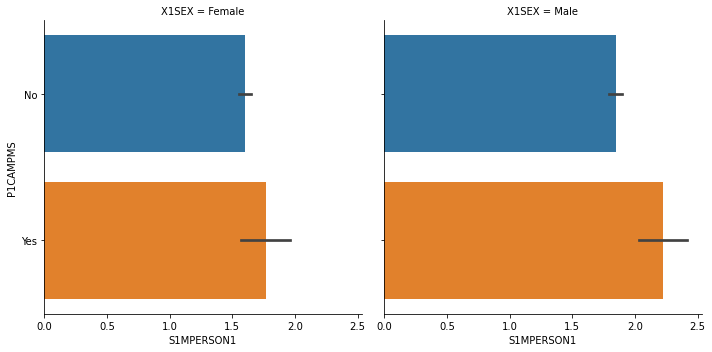

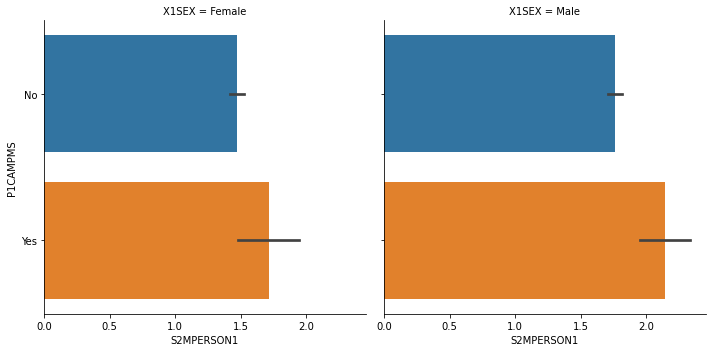

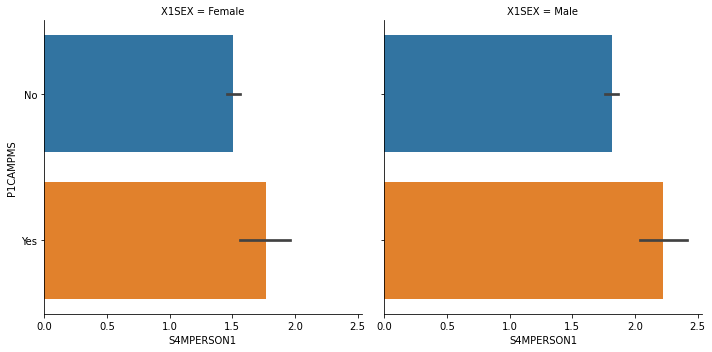

### P1JOBONET1_STEM1: P1 C08D Parent 1's job's STEM code 1 (sub-domain)

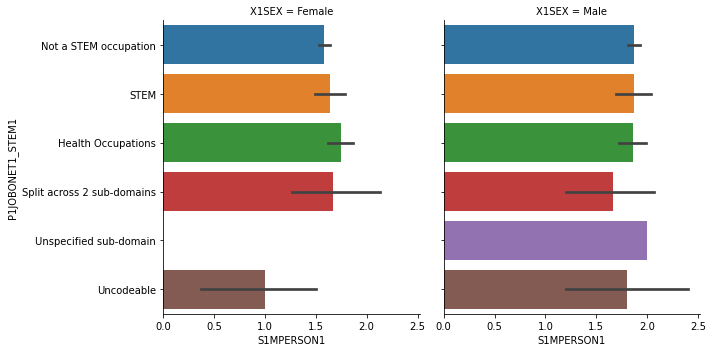

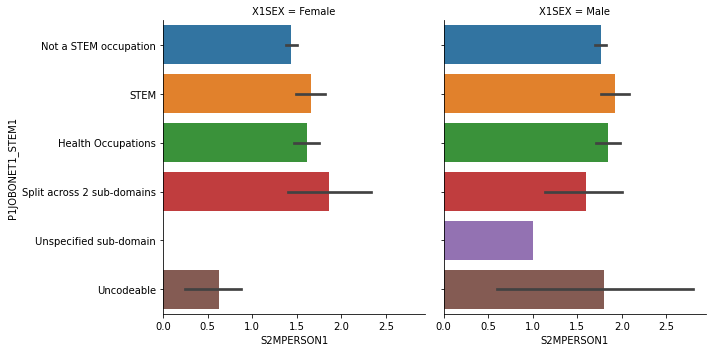

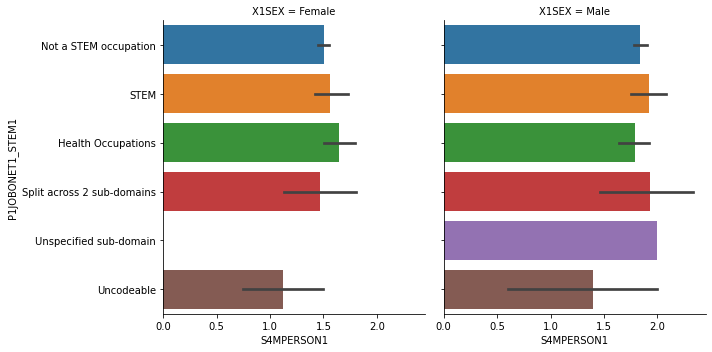

### P1JOBONET2_STEM1: P1 C16D Parent 2's job's STEM code 1 (sub-domain)

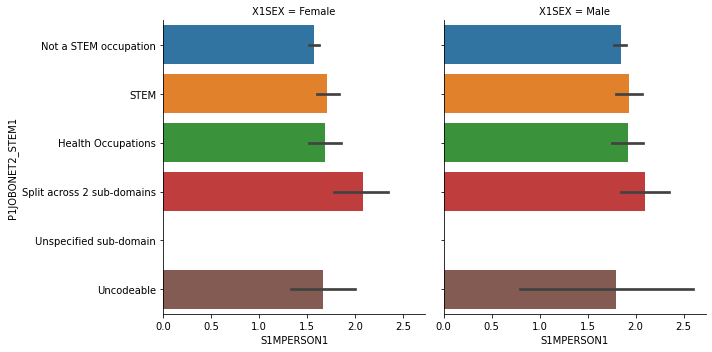

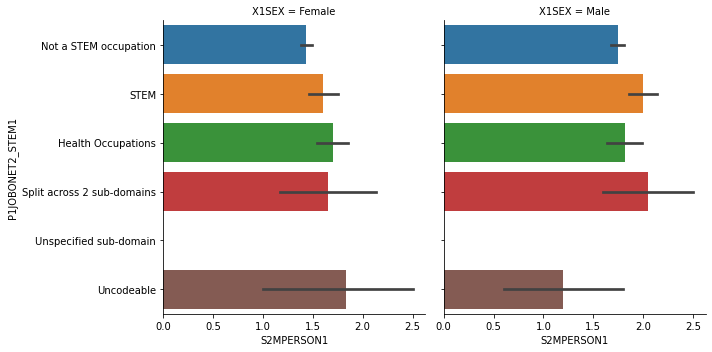

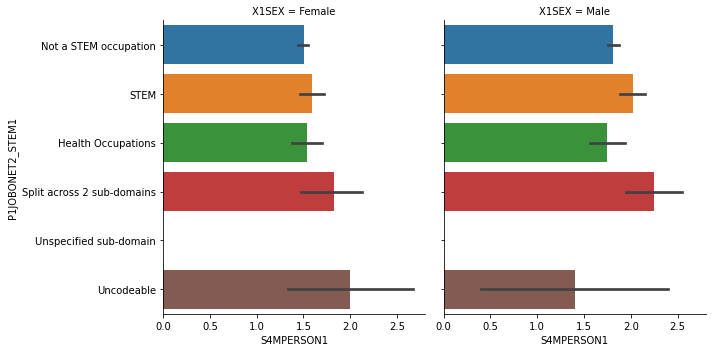

### P1STEMDISC: P1 E07F Discussed STEM program or article with 9th grader in last year

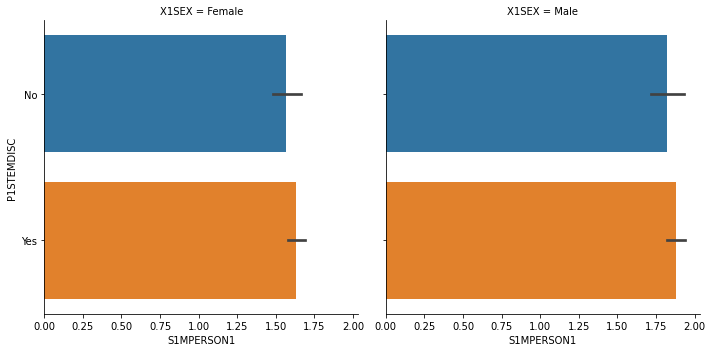

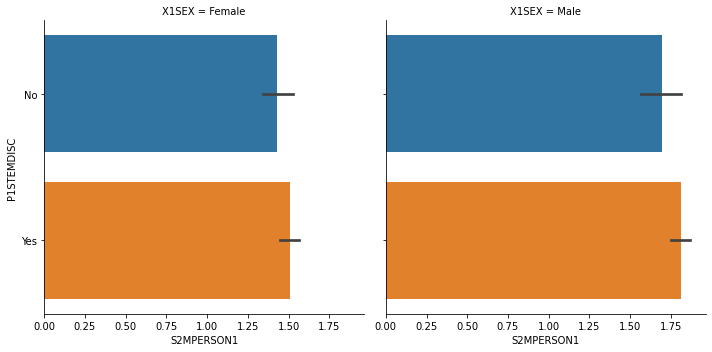

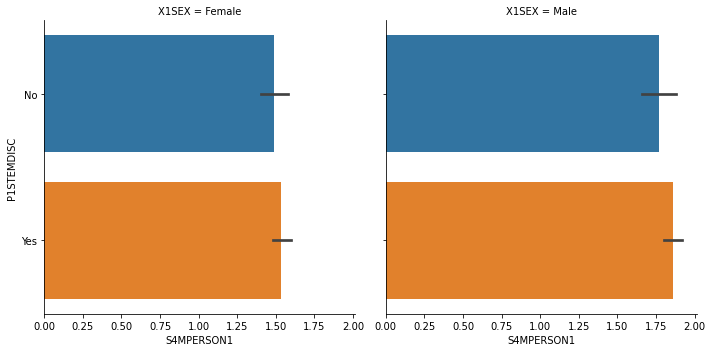

### P1MUSEUM: P1 E07A Went to science or engineering museum with 9th grader in last year

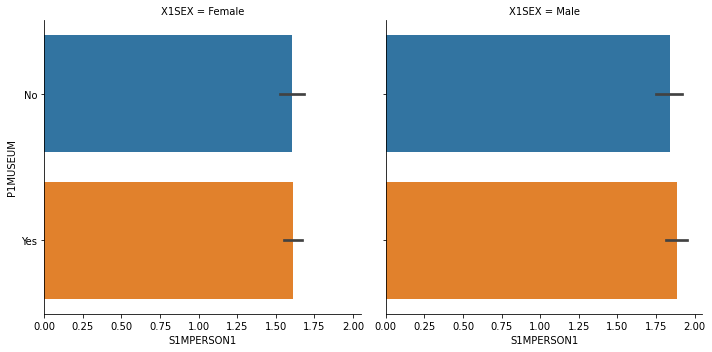

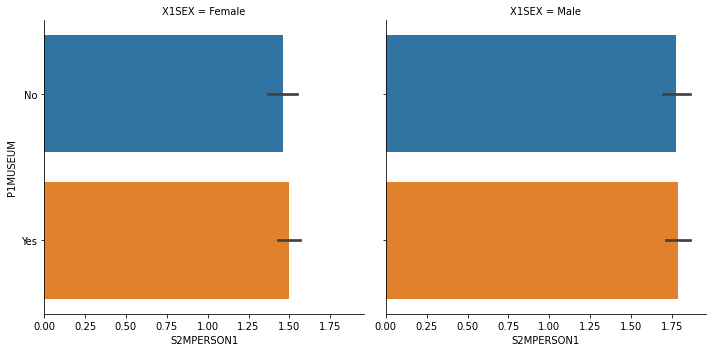

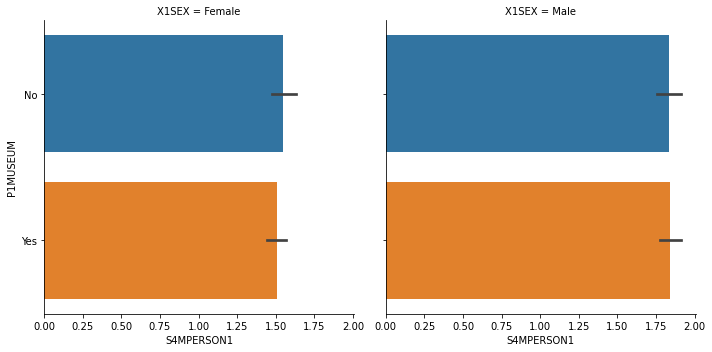

### P1COMPUTER: P1 E07B Worked or played on computer with 9th grader in last year

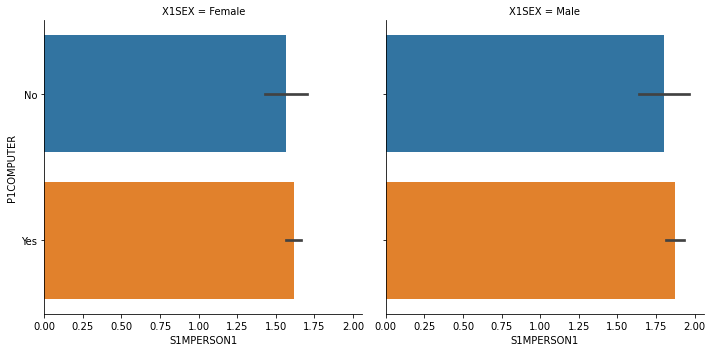

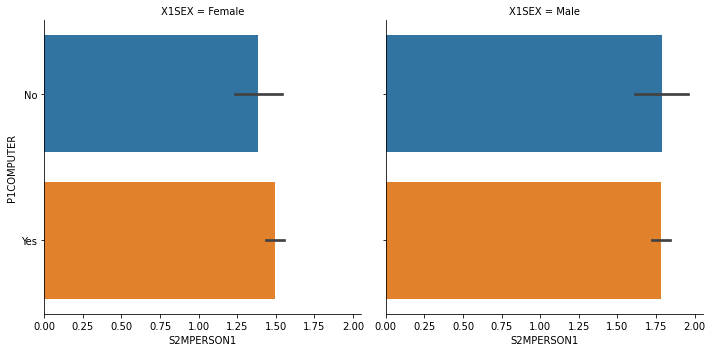

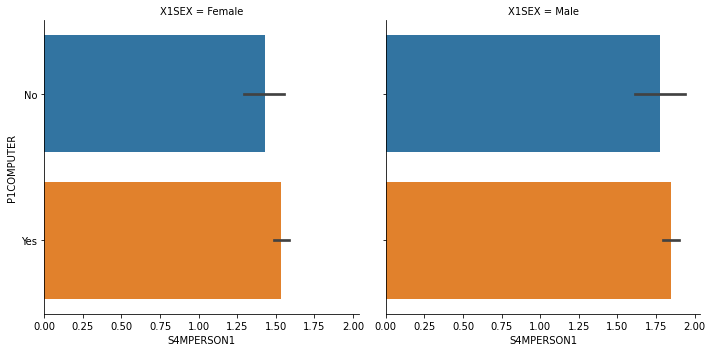

### P1FIXED: P1 E07C Built or fixed something with 9th grader in last year

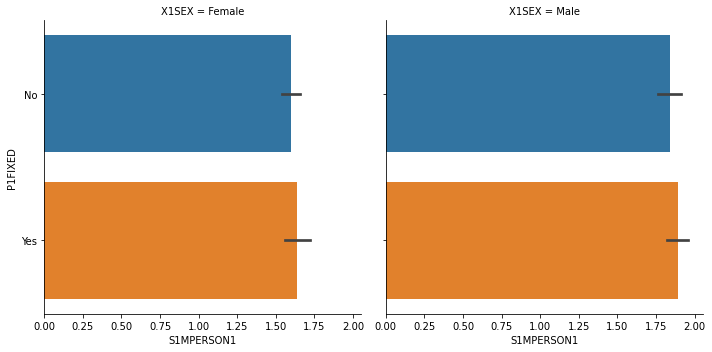

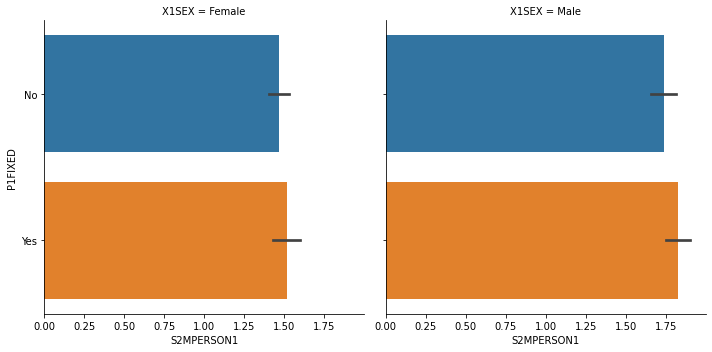

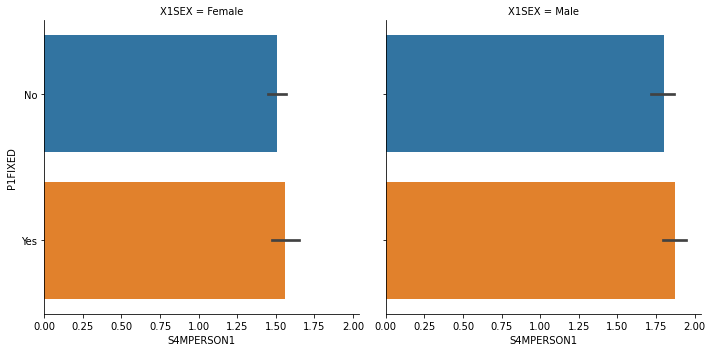

### P1SCIFAIR: P1 E07D Attended a school science fair with 9th grader in last year

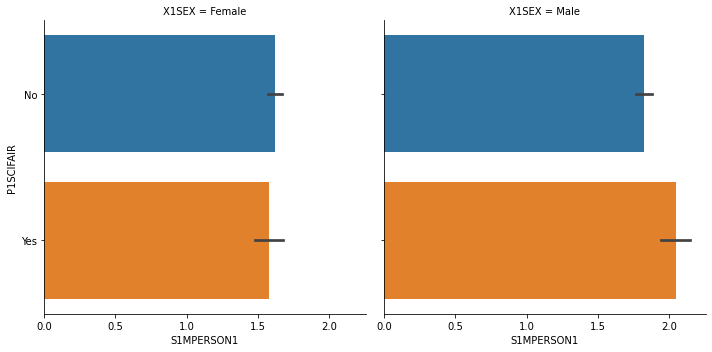

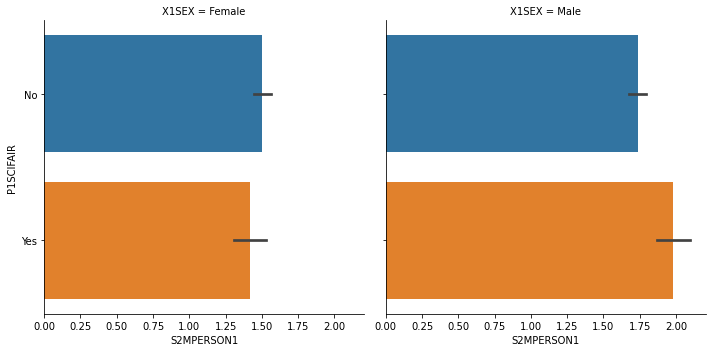

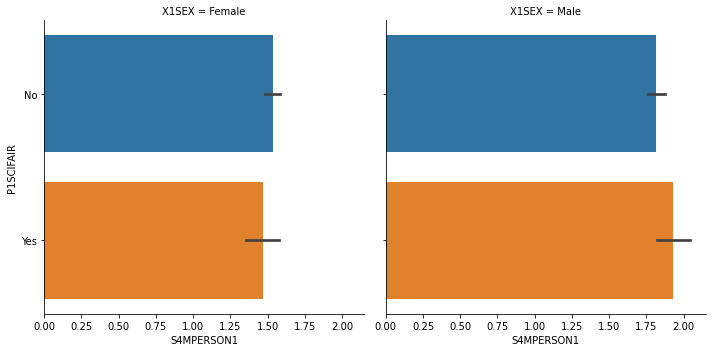

### P1SCIPROJ: P1 E07E Helped 9th grader with a school science fair project in last year

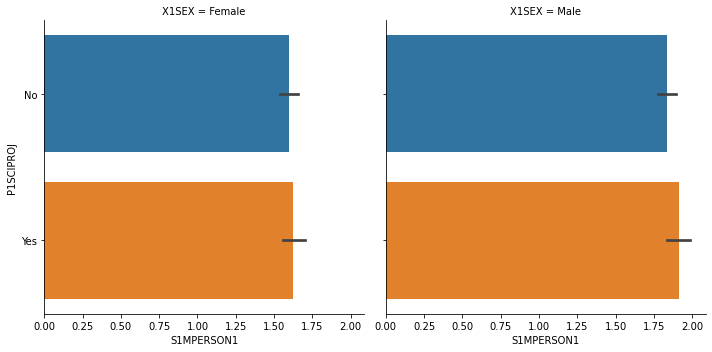

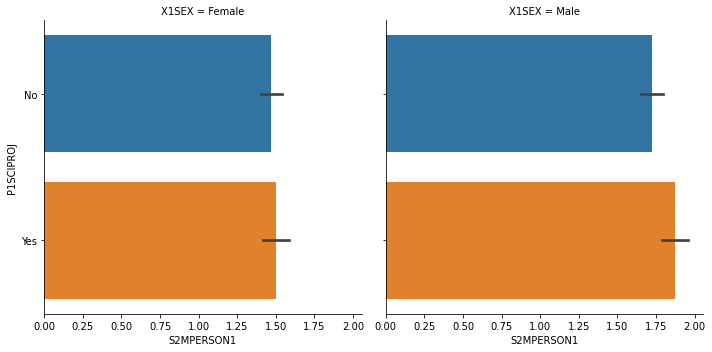

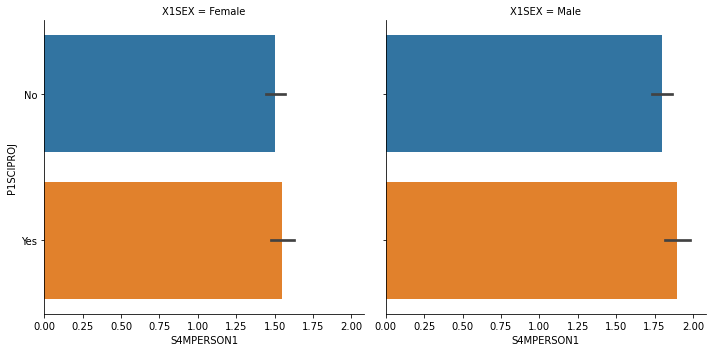

### P1MTHHWEFF: P1 E04A Confidence in helping with 9th grade math homework

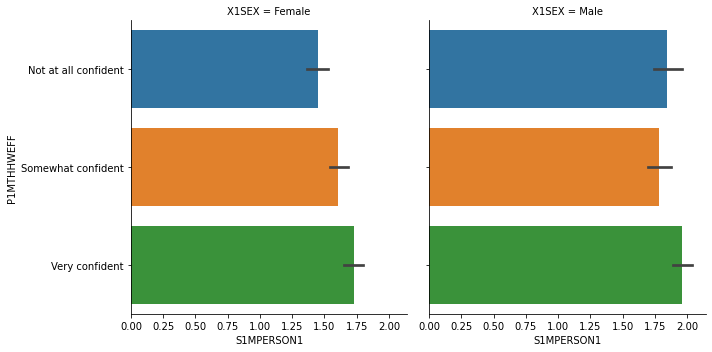

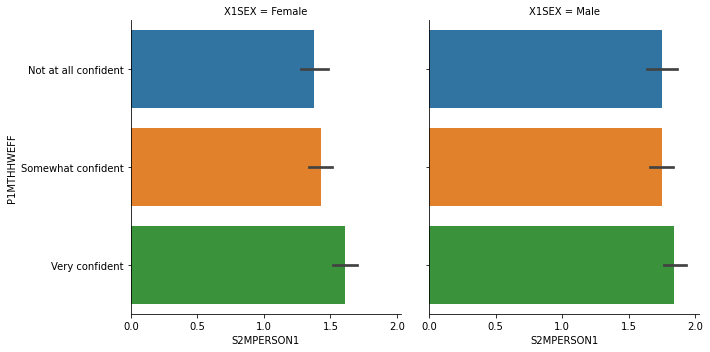

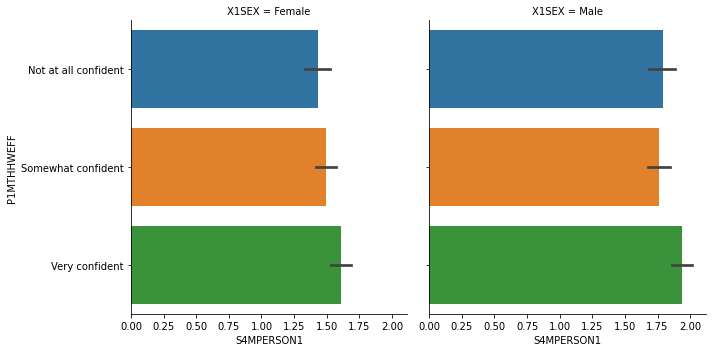

### P1SCIHWEFF: P1 E04B Confidence in helping with 9th grade science homework

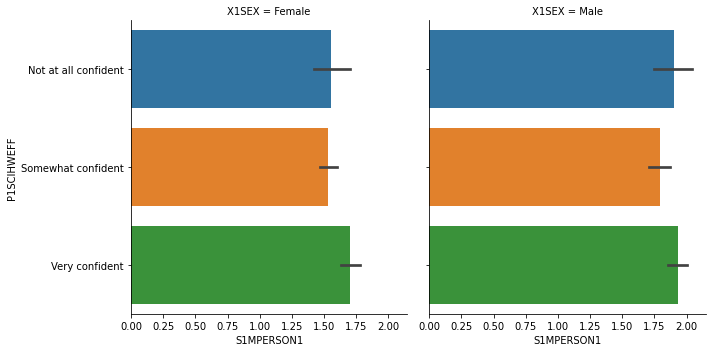

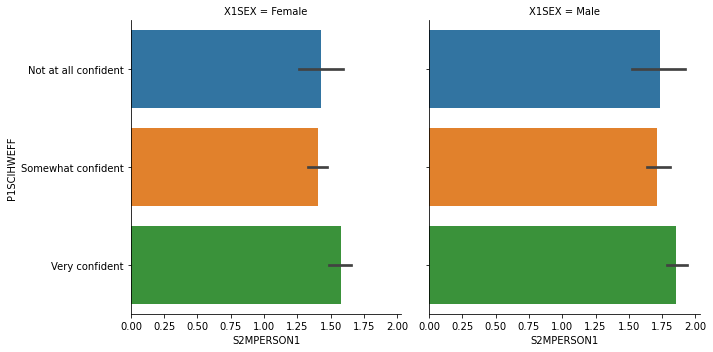

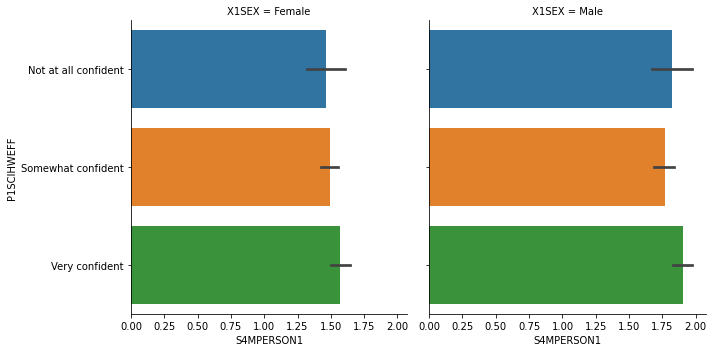

In [14]:
for item in parent_items:
    define_plot(item)